# Covid sample classification

# Get data

In this tutorial, we will run all tutorials with a set of 6 PBMC 10x datasets from 3 covid-19 patients and 3 healthy controls, <ins>the samples have been subsampled to 1500 cells per sample.</ins> They are part of the github repo and if you have cloned the repo they should be available in folder: `labs/data/covid_data_GSE149689`. Instructions on how to download them can also be found in the Precourse material.

In [1]:
# %%bash
# # create a data directory.
# mkdir -p data/raw

# # first check if the files are there
# count=$(ls -l data/raw/*.h5 | grep -v ^d | wc -l )
# echo $count

# # if not 4 files, fetch the files from github.
# if (("$count" <  6)); then
#   cd data/raw
#   curl -O https://raw.githubusercontent.com/NBISweden/workshop-scRNAseq/new_dataset/labs/data/covid_data_GSE149689/sub/Normal_PBMC_13.h5
#   curl -O https://raw.githubusercontent.com/NBISweden/workshop-scRNAseq/new_dataset/labs/data/covid_data_GSE149689/sub/Normal_PBMC_14.h5
#   curl -O https://raw.githubusercontent.com/NBISweden/workshop-scRNAseq/new_dataset/labs/data/covid_data_GSE149689/sub/Normal_PBMC_5.h5
#   curl -O https://raw.githubusercontent.com/NBISweden/workshop-scRNAseq/new_dataset/labs/data/covid_data_GSE149689/sub/nCoV_PBMC_15.h5
#   curl -O https://raw.githubusercontent.com/NBISweden/workshop-scRNAseq/new_dataset/labs/data/covid_data_GSE149689/sub/nCoV_PBMC_17.h5
#   curl -O https://raw.githubusercontent.com/NBISweden/workshop-scRNAseq/new_dataset/labs/data/covid_data_GSE149689/sub/nCoV_PBMC_1.h5
#   cd ../..
# fi

# ls -lGa data/raw

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
# gives error!! sc.logging.print_versions()

import warnings

warnings.filterwarnings("ignore")

sc.settings.set_figure_params(dpi=80)

We can first load the data individually by reading directly from HDF5 file format (.h5).

The h5 file consists of `matrix.mtx`, `barcodes.tsv`, and `genes.tsv.`

*genome is the symbol of gene. <br>
-> As used in MGI, a "gene symbol" is a unique abbreviation for the gene name.

In [3]:
data_cov1 = sc.read_10x_h5("./data/raw/nCoV_PBMC_1.h5")
data_cov1.var_names_make_unique()
data_cov15 = sc.read_10x_h5("./data/raw/nCoV_PBMC_15.h5")
data_cov15.var_names_make_unique()
data_cov17 = sc.read_10x_h5("./data/raw/nCoV_PBMC_17.h5")
data_cov17.var_names_make_unique()
data_ctrl5 = sc.read_10x_h5("./data/raw/Normal_PBMC_5.h5")
data_ctrl5.var_names_make_unique()
data_ctrl13 = sc.read_10x_h5("./data/raw/Normal_PBMC_13.h5")
data_ctrl13.var_names_make_unique()
data_ctrl14 = sc.read_10x_h5("./data/raw/Normal_PBMC_14.h5")
data_ctrl14.var_names_make_unique()

reading ./data/raw/nCoV_PBMC_1.h5
 (0:00:00)
reading ./data/raw/nCoV_PBMC_15.h5
 (0:00:00)
reading ./data/raw/nCoV_PBMC_17.h5
 (0:00:00)
reading ./data/raw/Normal_PBMC_5.h5
 (0:00:00)
reading ./data/raw/Normal_PBMC_13.h5
 (0:00:00)
reading ./data/raw/Normal_PBMC_14.h5
 (0:00:00)


# Create one merged object


In [4]:
data_cov1.obs["type"] = "Covid"
data_cov1.obs["sample"] = "covid_1"
data_cov15.obs["type"] = "Covid"
data_cov15.obs["sample"] = "covid_15"
data_cov17.obs["type"] = "Covid"
data_cov17.obs["sample"] = "covid_17"
data_ctrl5.obs["type"] = "Ctrl"
data_ctrl5.obs["sample"] = "ctrl_5"
data_ctrl13.obs["type"] = "Ctrl"
data_ctrl13.obs["sample"] = "ctrl_13"
data_ctrl14.obs["type"] = "Ctrl"
data_ctrl14.obs["sample"] = "ctrl_14"


# merge into one object.
adata = data_cov1.concatenate(data_cov15, data_cov17, data_ctrl5, data_ctrl13, data_ctrl14)

# and delete individual datasets to save space
del (data_cov1, data_cov15, data_cov17)
del (data_ctrl5, data_ctrl13, data_ctrl14)

 You can print a summary of the datasets in the Scanpy object, or a summary of the whole object.


In [5]:
print(adata.obs["sample"].value_counts())

adata

covid_1     1500
covid_15    1500
covid_17    1500
ctrl_5      1500
ctrl_13     1500
ctrl_14     1500
Name: sample, dtype: int64


AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

# Calculate QC

Having the data in a suitable format, we can start calculating some quality metrics. We can for example calculate the percentage of mitocondrial and ribosomal genes per cell and add to the metadata. This will be helpfull to visualize them across different metadata parameteres (i.e. datasetID and chemistry version). There are several ways of doing this, and here manually calculate the proportion of mitochondrial reads and add to the metadata table.

Citing from "Simple Single Cell" workflows (Lun, McCarthy & Marioni, 2017): "High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane."

First, let Scanpy calculate some general qc-stats for genes and cells with the function `sc.pp.calculate_qc_metrics`, similar to `calculateQCmetrics` in Scater. It can also calculate proportion of counts for specific gene populations, so first we need to define which genes are mitochondrial, ribosomal and hemoglogin.


In [6]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

adata.var

gene_ids    feature_types  genome     mt   ribo     hb
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  False  False  False
FAM138A      ENSG00000237613  Gene Expression  GRCh38  False  False  False
OR4F5        ENSG00000186092  Gene Expression  GRCh38  False  False  False
AL627309.1   ENSG00000238009  Gene Expression  GRCh38  False  False  False
AL627309.3   ENSG00000239945  Gene Expression  GRCh38  False  False  False
...                      ...              ...     ...    ...    ...    ...
AC233755.2   ENSG00000277856  Gene Expression  GRCh38  False  False  False
AC233755.1   ENSG00000275063  Gene Expression  GRCh38  False  False  False
AC240274.1   ENSG00000271254  Gene Expression  GRCh38  False  False  False
AC213203.1   ENSG00000277475  Gene Expression  GRCh38  False  False  False
FAM231C      ENSG00000268674  Gene Expression  GRCh38  False  False  False

[33538 rows x 6 columns]

In [7]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], percent_top=None, log1p=False, inplace=True)

In [8]:
adata.obs

type   sample batch  n_genes_by_counts  total_counts  \
AGGGTCCCATGACCCG-1-0   Covid  covid_1     0               2140        7698.0   
TACCCACAGCGGGTTA-1-0   Covid  covid_1     0               3391       13416.0   
CCCAACTTCATATGGC-1-0   Covid  covid_1     0               3654       16498.0   
TCAAGTGTCCGAACGC-1-0   Covid  covid_1     0                608        1425.0   
ATTCCTAGTGACTGTT-1-0   Covid  covid_1     0               1808        7535.0   
...                      ...      ...   ...                ...           ...   
CGCATAATCTTACGGA-14-5   Ctrl  ctrl_14     5               1460        3583.0   
GAGGCCTTCTCCTGCA-14-5   Ctrl  ctrl_14     5               1155        2711.0   
CCCTAACAGTTTCTTC-14-5   Ctrl  ctrl_14     5               1921        5913.0   
GGGATGATCAAGCTTG-14-5   Ctrl  ctrl_14     5               1926        7393.0   
CAATGACCACTGCATA-14-5   Ctrl  ctrl_14     5               2075        6220.0   

                       total_counts_mt  pct_counts_mt  total_counts_ribo  \
AGGGTCCCATGACCCG-1-0             525.0       6.819953             2564.0   
TACCCACAGCGGGTTA-1-0             952.0       7.096004             2264.0   
CCCAACTTCATATGGC-1-0            1253.0       7.594861             2723.0   
TCAAGTGTCCGAACGC-1-0             141.0       9.894737              444.0   
ATTCCTAGTGACTGTT-1-0             470.0       6.237558             3397.0   
...                                ...            ...                ...   
CGCATAATCTTACGGA-14-5            358.0       9.991627              563.0   
GAGGCCTTCTCCTGCA-14-5             96.0       3.541129              608.0   
CCCTAACAGTTTCTTC-14-5            235.0       3.974294             1813.0   
GGGATGATCAAGCTTG-14-5            385.0       5.207629             3001.0   
CAATGACCACTGCATA-14-5            415.0       6.672026             1572.0   

                       pct_counts_ribo  total_counts_hb  pct_counts_hb  
AGGGTCCCATGACCCG-1-0         33.307354              2.0       0.025981  
TACCCACAGCGGGTTA-1-0         16.875372              6.0       0.044723  
CCCAACTTCATATGGC-1-0         16.505032              1.0       0.006061  
TCAAGTGTCCGAACGC-1-0         31.157896              1.0       0.070175  
ATTCCTAGTGACTGTT-1-0         45.082947              4.0       0.053086  
...                                ...              ...            ...  
CGCATAATCTTACGGA-14-5        15.713090              0.0       0.000000  
GAGGCCTTCTCCTGCA-14-5        22.427149             25.0       0.922169  
CCCTAACAGTTTCTTC-14-5        30.661255              0.0       0.000000  
GGGATGATCAAGCTTG-14-5        40.592453              0.0       0.000000  
CAATGACCACTGCATA-14-5        25.273312              1.0       0.016077  

[9000 rows x 11 columns]

In [9]:
mito_genes = adata.var_names.str.startswith("MT-")
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs["percent_mt2"] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs["n_counts"] = adata.X.sum(axis=1).A1

 Now you can see that we have additional data in the scanpy `obs` slot.

In [10]:
adata
# adata.obs['n_counts'] # == total_counts

AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Plot QC

Now we can plot some of the QC-features as violin plots.


In [11]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    groupby="sample",
    rotation=45,
)

As you can see, there is quite some difference in quality for the 4 datasets, with for instance the covid_15 sample having fewer cells with many detected genes and more mitochondrial content. As the ribosomal proteins are highly expressed they will make up a larger proportion of the transcriptional landscape when fewer of the lowly expressed genes are detected. And we can plot the different QC-measures as scatter plots.


In [12]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", color="sample")

# Filtering

A standard approach is to filter cells with low amount of reads as well as genes that are present in at least a certain amount of cells. Here we will only consider cells with at least 200 detected genes and genes need to be expressed in at least 3 cells. Please note that those values are highly dependent on the library preparation method used.


In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

filtered out 1021 cells that have less than 200 genes expressed
filtered out 14760 genes that are detected in less than 3 cells
7979 18778


Additionally, we can also see which genes contribute the most to such reads. We can for instance plot the percentage of counts per gene.


normalizing counts per cell
    finished (0:00:00)


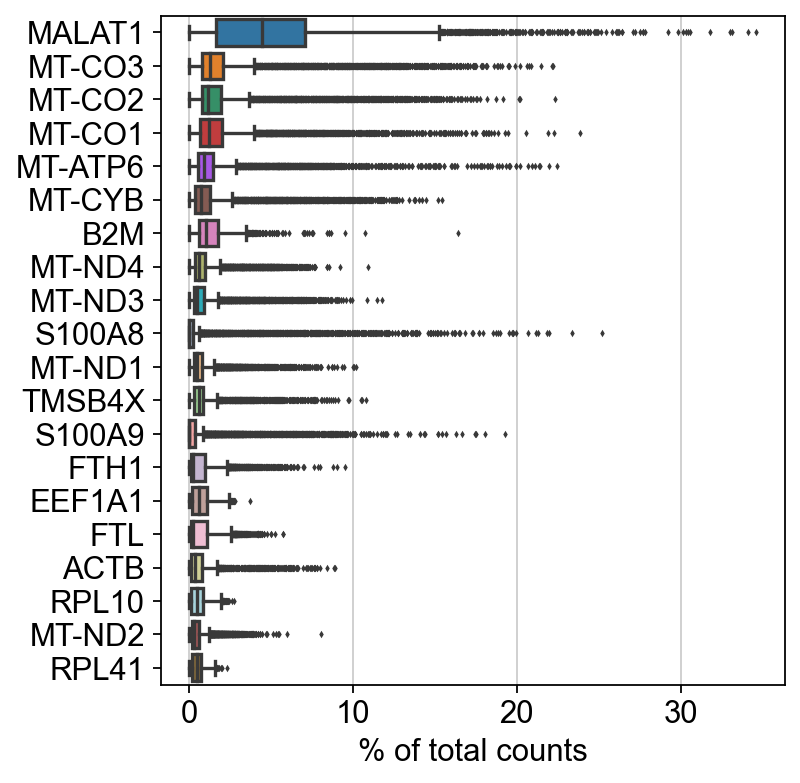

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)

As you can see, MALAT1 constitutes up to 30% of the UMIs from a single cell and the other top genes are mitochondrial and ribosomal genes. It is quite common that nuclear lincRNAs have correlation with quality and mitochondrial reads, so high detection of MALAT1 may be a technical issue. Let us assemble some information about such genes, which are important for quality control and downstream filtering.

## Mito/Ribo filtering

We also have quite a lot of cells with high proportion of mitochondrial and low proportion of ribosomal reads. It could be wise to remove those cells, if we have enough cells left after filtering. <br>Another option would be to either remove all mitochondrial reads from the dataset and hope that the remaining genes still have enough biological signal. <br>A third option would be to just regress out the `percent_mito` variable during scaling. In this case we had as much as 99.7% mitochondrial reads in some of the cells, so it is quite unlikely that there is much cell type signature left in those. <br>Looking at the plots, make reasonable decisions on where to draw the cutoff. In this case, the bulk of the cells are below 20% mitochondrial reads and that will be used as a cutoff. We will also remove cells with less than 5% ribosomal reads.


In [15]:
# filter for percent mito
adata = adata[adata.obs["pct_counts_mt"] < 20, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs["pct_counts_ribo"] > 5, :]

print("Remaining cells %d" % adata.n_obs)

Remaining cells 5762


In [16]:
print(adata.obs["sample"].value_counts())

ctrl_13     1154
ctrl_14     1063
covid_17    1042
ctrl_5      1040
covid_1      878
covid_15     585
Name: sample, dtype: int64


 As you can see, a large proportion of sample covid_15 is filtered out. Also, there is still quite a lot of variation in `percent_mito`, so it will have to be dealt with in the data analysis step. We can also notice that the `percent_ribo` are also highly variable, but that is expected since different cell types have different proportions of ribosomal content, according to their function.

## Plot filtered QC

Lets plot the same QC-stats another time.


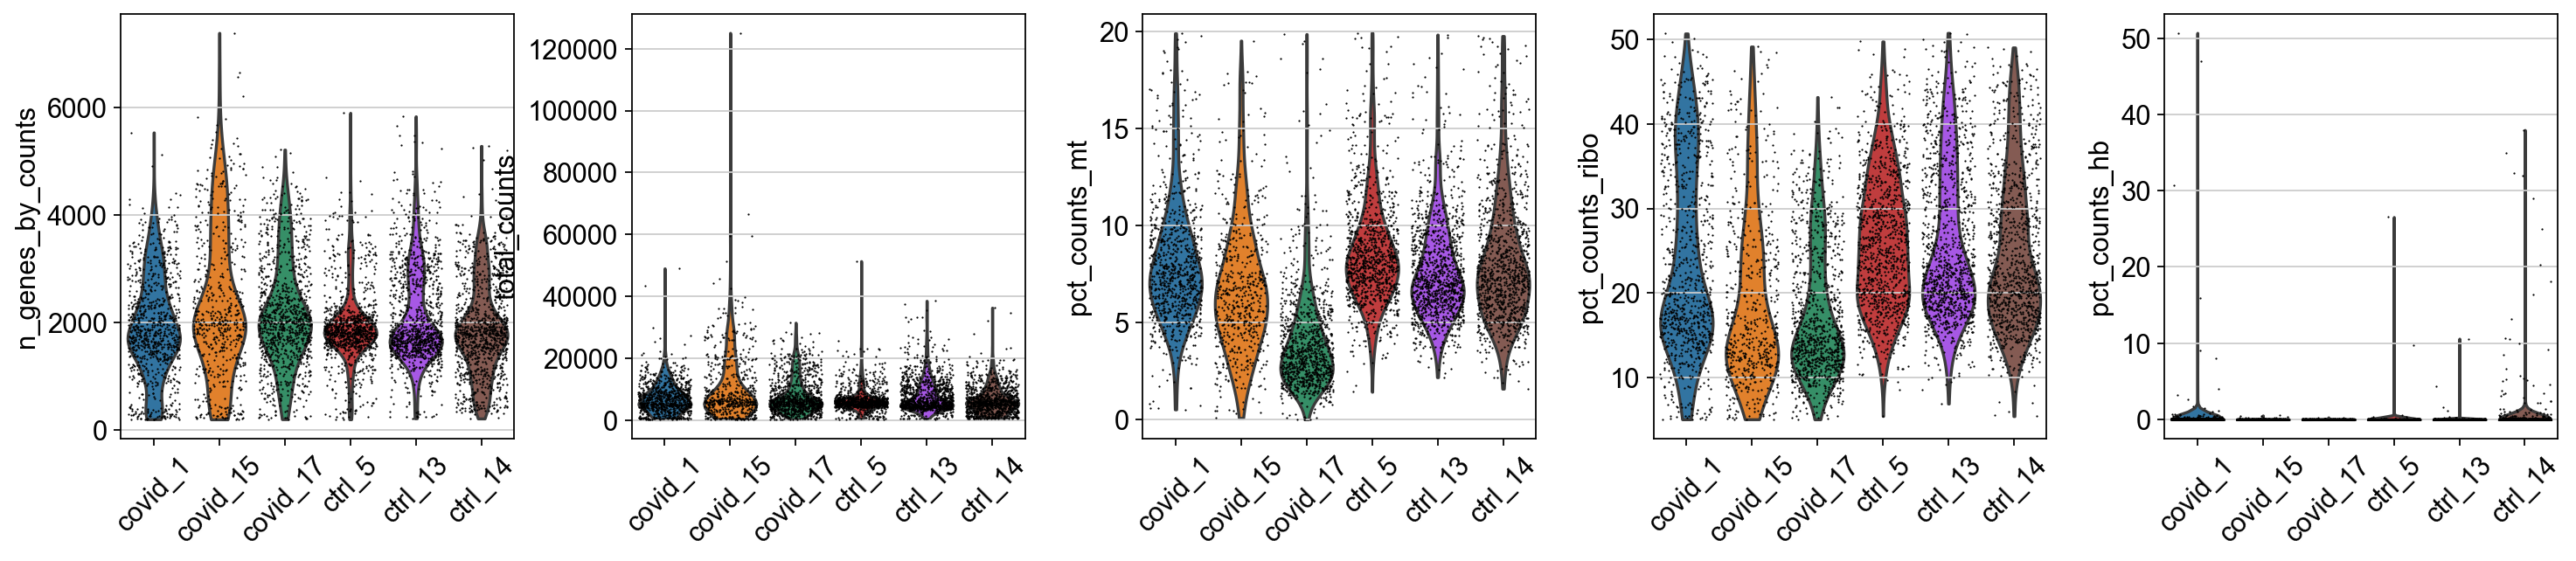

In [17]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    groupby="sample",
    rotation=45,
)

## Filter genes

As the level of expression of mitochondrial and MALAT1 genes are judged as mainly technical, it can be wise to remove them from the dataset bofore any further analysis.


In [18]:
malat1 = adata.var_names.str.startswith("MALAT1")
# we need to redefine the mito_genes since they were first
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith("MT-")
hb_genes = adata.var_names.str.contains("^HB[^(P)]")

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:, keep]

print(adata.n_obs, adata.n_vars)

5762 18752


# Sample sex (Optional)

When working with human or animal samples, you should ideally constrain you experiments to a single sex to avoid including sex bias in the conclusions. However this may not always be possible. By looking at reads from chromosomeY (males) and XIST (X-inactive specific transcript) expression (mainly female) it is quite easy to determine per sample which sex it is. It can also bee a good way to detect if there has been any sample mixups, if the sample metadata sex does not agree with the computational predictions.

To get choromosome information for all genes, you should ideally parse the information from the gtf file that you used in the mapping pipeline as it has the exact same annotation version/gene naming. However, it may not always be available, as in this case where we have downloaded public data. Hence, we will use biomart to fetch chromosome information.

In [19]:
annot = sc.queries.biomart_annotations(
    "hsapiens",
    ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
).set_index("external_gene_name")
# >>> adata.var[annot.columns] = annot

HTTPError: 500 Server Error: Internal Server Error for url: http://www.ensembl.org:80/biomart/martservice?type=registry

Now that we have the chromosome information, we can calculate per cell the proportion of reads that comes from chromosome Y.


In [ ]:
chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['RPS4Y1', 'ZFY', 'ZFY-AS1', 'LINC00278', 'PCDH11Y', 'USP9Y', 'DDX3Y',
       'UTY', 'TMSB4Y', 'NLGN4Y', 'TTTY14', 'KDM5D', 'EIF1AY', 'RPS4Y2'],
      dtype='object')

In [ ]:
adata.obs["percent_chrY"] = np.sum(adata[:, chrY_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 * 100

In [ ]:
adata.obs

type   sample batch  n_genes_by_counts  total_counts  \
AGGGTCCCATGACCCG-1-0   Covid  covid_1     0               2140        7698.0   
TACCCACAGCGGGTTA-1-0   Covid  covid_1     0               3391       13416.0   
CCCAACTTCATATGGC-1-0   Covid  covid_1     0               3654       16498.0   
TCAAGTGTCCGAACGC-1-0   Covid  covid_1     0                608        1425.0   
ATTCCTAGTGACTGTT-1-0   Covid  covid_1     0               1808        7535.0   
...                      ...      ...   ...                ...           ...   
CGCATAATCTTACGGA-14-5   Ctrl  ctrl_14     5               1460        3583.0   
GAGGCCTTCTCCTGCA-14-5   Ctrl  ctrl_14     5               1155        2711.0   
CCCTAACAGTTTCTTC-14-5   Ctrl  ctrl_14     5               1921        5913.0   
GGGATGATCAAGCTTG-14-5   Ctrl  ctrl_14     5               1926        7393.0   
CAATGACCACTGCATA-14-5   Ctrl  ctrl_14     5               2075        6220.0   

                       total_counts_mt  pct_counts_mt  total_counts_ribo  \
AGGGTCCCATGACCCG-1-0             525.0       6.819953             2564.0   
TACCCACAGCGGGTTA-1-0             952.0       7.096004             2264.0   
CCCAACTTCATATGGC-1-0            1253.0       7.594861             2723.0   
TCAAGTGTCCGAACGC-1-0             141.0       9.894737              444.0   
ATTCCTAGTGACTGTT-1-0             470.0       6.237558             3397.0   
...                                ...            ...                ...   
CGCATAATCTTACGGA-14-5            358.0       9.991627              563.0   
GAGGCCTTCTCCTGCA-14-5             96.0       3.541129              608.0   
CCCTAACAGTTTCTTC-14-5            235.0       3.974294             1813.0   
GGGATGATCAAGCTTG-14-5            385.0       5.207629             3001.0   
CAATGACCACTGCATA-14-5            415.0       6.672026             1572.0   

                       pct_counts_ribo  total_counts_hb  pct_counts_hb  \
AGGGTCCCATGACCCG-1-0         33.307354              2.0       0.025981   
TACCCACAGCGGGTTA-1-0         16.875372              6.0       0.044723   
CCCAACTTCATATGGC-1-0         16.505032              1.0       0.006061   
TCAAGTGTCCGAACGC-1-0         31.157896              1.0       0.070175   
ATTCCTAGTGACTGTT-1-0         45.082947              4.0       0.053086   
...                                ...              ...            ...   
CGCATAATCTTACGGA-14-5        15.713090              0.0       0.000000   
GAGGCCTTCTCCTGCA-14-5        22.427149             25.0       0.922169   
CCCTAACAGTTTCTTC-14-5        30.661255              0.0       0.000000   
GGGATGATCAAGCTTG-14-5        40.592453              0.0       0.000000   
CAATGACCACTGCATA-14-5        25.273312              1.0       0.016077   

                       percent_mt2  n_counts  n_genes  percent_chrY  
AGGGTCCCATGACCCG-1-0      0.068200    7698.0     2140      0.161741  
TACCCACAGCGGGTTA-1-0      0.070960   13416.0     3391      0.057129  
CCCAACTTCATATGGC-1-0      0.075949   16498.0     3654      0.060237  
TCAAGTGTCCGAACGC-1-0      0.098947    1425.0      608      0.174978  
ATTCCTAGTGACTGTT-1-0      0.062376    7535.0     1808      0.179641  
...                            ...       ...      ...           ...  
CGCATAATCTTACGGA-14-5     0.099916    3583.0     1460      0.000000  
GAGGCCTTCTCCTGCA-14-5     0.035411    2711.0     1155      0.000000  
CCCTAACAGTTTCTTC-14-5     0.039743    5913.0     1921      0.000000  
GGGATGATCAAGCTTG-14-5     0.052076    7393.0     1926      0.000000  
CAATGACCACTGCATA-14-5     0.066720    6220.0     2075      0.000000  

[5762 rows x 15 columns]

Then plot XIST expression vs chrY proportion. As you can see, the samples are clearly on either side, even if some cells do not have detection of either.


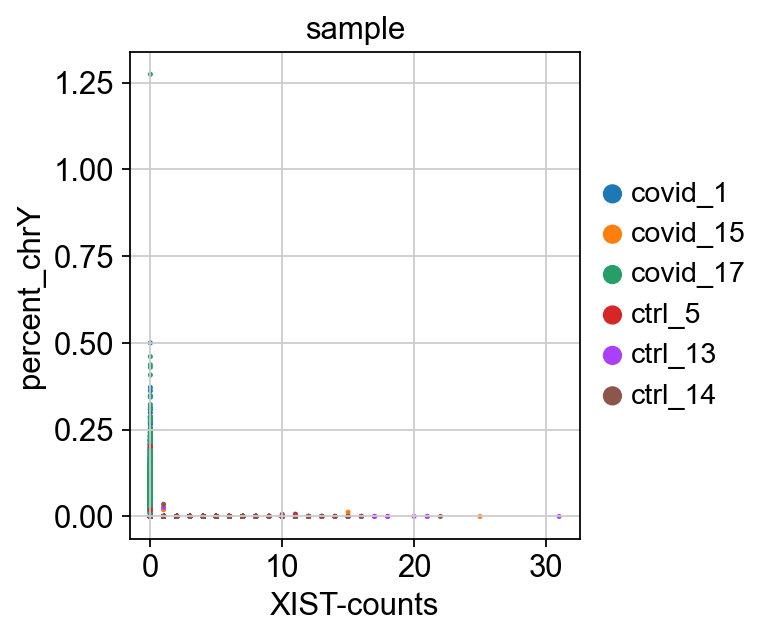

In [ ]:
# color inputs must be from either .obs or .var, so add in XIST expression to obs.
adata.obs["XIST-counts"] = adata.X[:, adata.var_names.str.match("XIST")].toarray()  # XIST is a gene!

sc.pl.scatter(adata, x="XIST-counts", y="percent_chrY", color="sample")

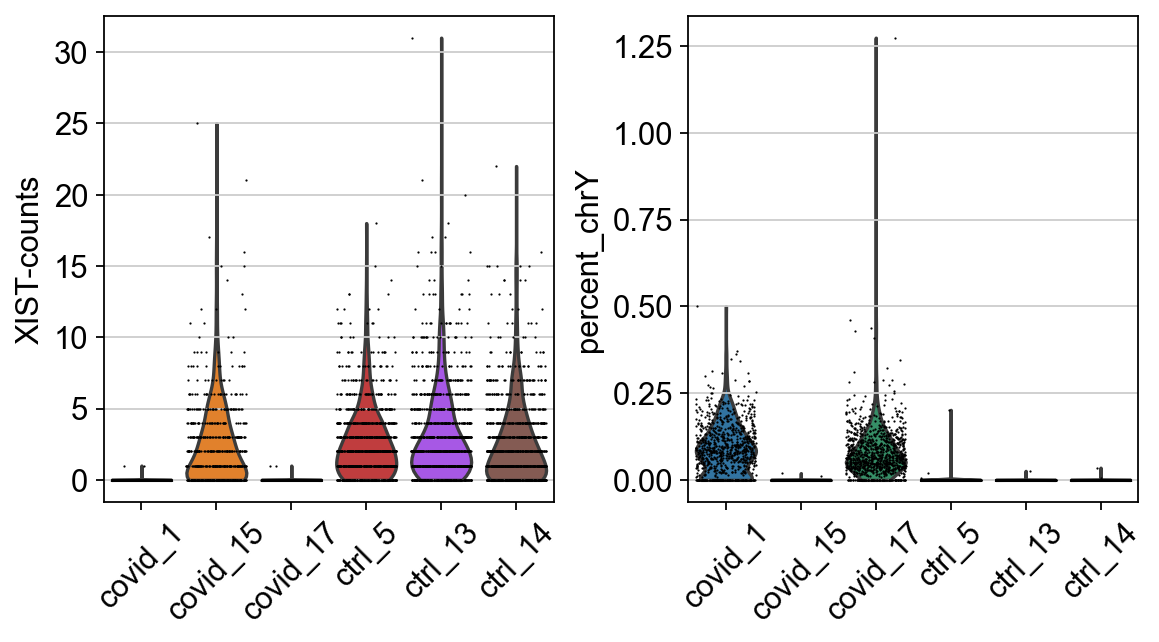

In [ ]:
sc.pl.violin(adata, ["XIST-counts", "percent_chrY"], jitter=0.4, groupby="sample", rotation=45)

Here, we can see clearly that we have two males (covid_1 and covid_17) and 4 females, can you see which samples they are? 
Do you think this will cause any problems for downstream analysis? Discuss with your group: what would be the best way to deal with this type of sex bias?


# Calculate cell-cycle scores

We here perform cell cycle scoring. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site via web browser at [RegevLab Github repo](https://github.com/theislab/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt).


Cell-cycle overview: <br>
<img src="./scanpy_01_qc_files/cell_cycle.png" width="500"> <br>

Furthermore, the reason of why we need to regress out the effect of cell-cycle written in a notebook is here: https://nbviewer.org/github/theislab/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb

In [20]:
#!if [ ! -f data/regev_lab_cell_cycle_genes.txt ]; then curl -o data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [21]:
cell_cycle_genes = [x.strip() for x in open("./data/regev_lab_cell_cycle_genes.txt")]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
94


 Before running cell cycle we have to normalize the data. In the scanpy object, the data slot will be overwritten with the normalized data. So first, save the raw data into the slot `raw`.  <br><br>Then run normalization, logarimize and scale the data.


In [22]:
# save normalized counts in raw slot.
adata.raw = adata

# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

# scale
sc.pp.scale(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


We here perform cell cycle scoring. The function is actually a wrapper to sc.tl.score_gene_list, which is launched twice, to score separately S and G2M phases. Both sc.tl.score_gene_list and sc.tl.score_cell_cycle_genes are a port from Seurat and are supposed to work in a very similar way. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.


In [23]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    729 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    772 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [24]:
adata.obs

type   sample batch  n_genes_by_counts  total_counts  \
AGGGTCCCATGACCCG-1-0   Covid  covid_1     0               2140        7698.0   
TACCCACAGCGGGTTA-1-0   Covid  covid_1     0               3391       13416.0   
CCCAACTTCATATGGC-1-0   Covid  covid_1     0               3654       16498.0   
TCAAGTGTCCGAACGC-1-0   Covid  covid_1     0                608        1425.0   
ATTCCTAGTGACTGTT-1-0   Covid  covid_1     0               1808        7535.0   
...                      ...      ...   ...                ...           ...   
CGCATAATCTTACGGA-14-5   Ctrl  ctrl_14     5               1460        3583.0   
GAGGCCTTCTCCTGCA-14-5   Ctrl  ctrl_14     5               1155        2711.0   
CCCTAACAGTTTCTTC-14-5   Ctrl  ctrl_14     5               1921        5913.0   
GGGATGATCAAGCTTG-14-5   Ctrl  ctrl_14     5               1926        7393.0   
CAATGACCACTGCATA-14-5   Ctrl  ctrl_14     5               2075        6220.0   

                       total_counts_mt  pct_counts_mt  total_counts_ribo  \
AGGGTCCCATGACCCG-1-0             525.0       6.819953             2564.0   
TACCCACAGCGGGTTA-1-0             952.0       7.096004             2264.0   
CCCAACTTCATATGGC-1-0            1253.0       7.594861             2723.0   
TCAAGTGTCCGAACGC-1-0             141.0       9.894737              444.0   
ATTCCTAGTGACTGTT-1-0             470.0       6.237558             3397.0   
...                                ...            ...                ...   
CGCATAATCTTACGGA-14-5            358.0       9.991627              563.0   
GAGGCCTTCTCCTGCA-14-5             96.0       3.541129              608.0   
CCCTAACAGTTTCTTC-14-5            235.0       3.974294             1813.0   
GGGATGATCAAGCTTG-14-5            385.0       5.207629             3001.0   
CAATGACCACTGCATA-14-5            415.0       6.672026             1572.0   

                       pct_counts_ribo  total_counts_hb  pct_counts_hb  \
AGGGTCCCATGACCCG-1-0         33.307354              2.0       0.025981   
TACCCACAGCGGGTTA-1-0         16.875372              6.0       0.044723   
CCCAACTTCATATGGC-1-0         16.505032              1.0       0.006061   
TCAAGTGTCCGAACGC-1-0         31.157896              1.0       0.070175   
ATTCCTAGTGACTGTT-1-0         45.082947              4.0       0.053086   
...                                ...              ...            ...   
CGCATAATCTTACGGA-14-5        15.713090              0.0       0.000000   
GAGGCCTTCTCCTGCA-14-5        22.427149             25.0       0.922169   
CCCTAACAGTTTCTTC-14-5        30.661255              0.0       0.000000   
GGGATGATCAAGCTTG-14-5        40.592453              0.0       0.000000   
CAATGACCACTGCATA-14-5        25.273312              1.0       0.016077   

                       percent_mt2  n_counts  n_genes   S_score  G2M_score  \
AGGGTCCCATGACCCG-1-0      0.068200    6801.0     2140 -0.041544  -0.369570   
TACCCACAGCGGGTTA-1-0      0.070960   12253.0     3391 -0.175093  -0.619071   
CCCAACTTCATATGGC-1-0      0.075949   14941.0     3654 -0.122379  -0.594659   
TCAAGTGTCCGAACGC-1-0      0.098947    1143.0      608 -0.017833  -0.062375   
ATTCCTAGTGACTGTT-1-0      0.062376    6680.0     1808 -0.046149  -0.400857   
...                            ...       ...      ...       ...        ...   
CGCATAATCTTACGGA-14-5     0.099916    2899.0     1460 -0.003135  -0.111798   
GAGGCCTTCTCCTGCA-14-5     0.035411    2367.0     1155 -0.007741  -0.097549   
CCCTAACAGTTTCTTC-14-5     0.039743    5133.0     1921 -0.055752  -0.220108   
GGGATGATCAAGCTTG-14-5     0.052076    6592.0     1926 -0.068097  -0.403647   
CAATGACCACTGCATA-14-5     0.066720    5516.0     2075 -0.000784  -0.276704   

                      phase  
AGGGTCCCATGACCCG-1-0     G1  
TACCCACAGCGGGTTA-1-0     G1  
CCCAACTTCATATGGC-1-0     G1  
TCAAGTGTCCGAACGC-1-0     G1  
ATTCCTAGTGACTGTT-1-0     G1  
...                     ...  
CGCATAATCTTACGGA-14-5    G1  
GAGGCCTTCTCCTGCA-14-5    G1  
CCCTAACAGTTTCTTC-14-5    G1  
GGGATGATCAAGCTTG-14-5   

We can now plot a violin plot for the cell cycle scores as well.


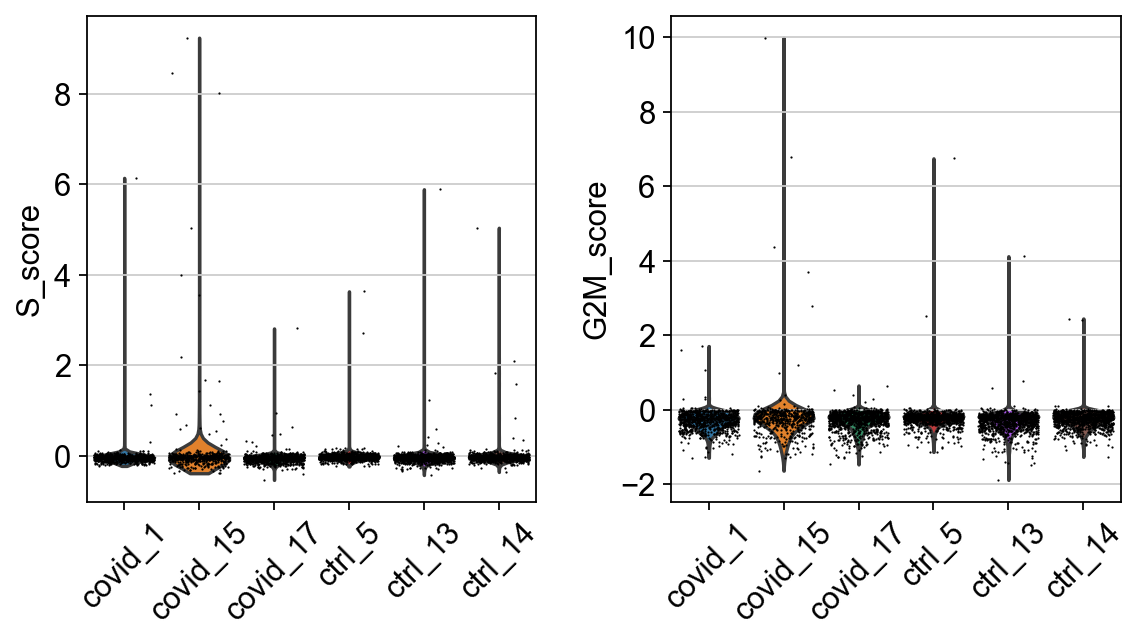

In [25]:
sc.pl.violin(adata, ["S_score", "G2M_score"], jitter=0.4, groupby="sample", rotation=45)

In this case it looks like we only have a few cycling cells in the datasets.

# Predict doublets

Doublets/Mulitples of cells in the same well/droplet is a common issue in scRNAseq protocols. Especially in droplet-based methods whith overloading of cells. In a typical 10x experiment the proportion of doublets is linearly dependent on the amount of loaded cells. As  indicated from the Chromium user guide, doublet rates are about as follows:
![](../../figs/10x_doublet_rate.png)
Most doublet detectors simulates doublets by merging cell counts and predicts doublets as cells that have similar embeddings as the simulated doublets. Most such packages need an assumption about the number/proportion of expected doublets in the dataset. The data you are using is subsampled, but the orignial datasets contained about 5 000 cells per sample, hence we can assume that they loaded about 9 000 cells and should have a doublet rate at about 4%.
OBS! Ideally doublet prediction should be run on each sample separately, especially if your different samples have different proportions of celltypes. In this case, the data is subsampled so we have very few cells per sample and all samples are sorted PBMCs so it is okay to run them together.

For doublet detection, we will use the package `Scrublet`, so first we need to get the raw counts from `adata.raw.X` and run scrublet with that matrix. Then we add in the doublet prediction info into our anndata object.


In [26]:
#!pip install scrublet

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 2.9%
Estimated detectable doublet fraction = 44.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.5%
Elapsed time: 3.7 seconds


168

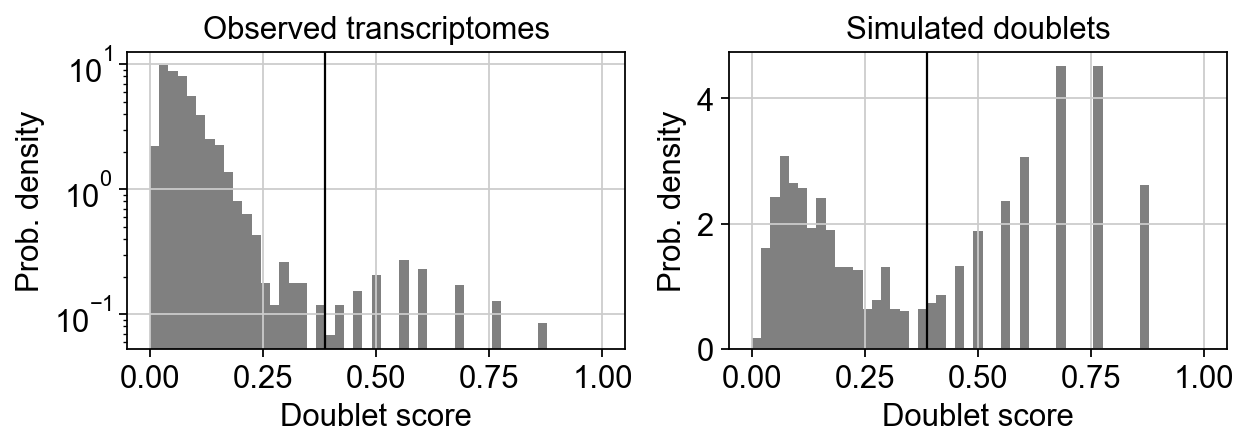

In [27]:
import scrublet as scr

scrub = scr.Scrublet(adata.raw.X)
adata.obs["doublet_scores"], adata.obs["predicted_doublets"] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs["predicted_doublets"])

In [28]:
# add in column with singlet/doublet instead of True/False
adata.obs["doublet_info"] = adata.obs["predicted_doublets"].astype(str)

In [29]:
adata.obs

type   sample batch  n_genes_by_counts  total_counts  \
AGGGTCCCATGACCCG-1-0   Covid  covid_1     0               2140        7698.0   
TACCCACAGCGGGTTA-1-0   Covid  covid_1     0               3391       13416.0   
CCCAACTTCATATGGC-1-0   Covid  covid_1     0               3654       16498.0   
TCAAGTGTCCGAACGC-1-0   Covid  covid_1     0                608        1425.0   
ATTCCTAGTGACTGTT-1-0   Covid  covid_1     0               1808        7535.0   
...                      ...      ...   ...                ...           ...   
CGCATAATCTTACGGA-14-5   Ctrl  ctrl_14     5               1460        3583.0   
GAGGCCTTCTCCTGCA-14-5   Ctrl  ctrl_14     5               1155        2711.0   
CCCTAACAGTTTCTTC-14-5   Ctrl  ctrl_14     5               1921        5913.0   
GGGATGATCAAGCTTG-14-5   Ctrl  ctrl_14     5               1926        7393.0   
CAATGACCACTGCATA-14-5   Ctrl  ctrl_14     5               2075        6220.0   

                       total_counts_mt  pct_counts_mt  total_counts_ribo  \
AGGGTCCCATGACCCG-1-0             525.0       6.819953             2564.0   
TACCCACAGCGGGTTA-1-0             952.0       7.096004             2264.0   
CCCAACTTCATATGGC-1-0            1253.0       7.594861             2723.0   
TCAAGTGTCCGAACGC-1-0             141.0       9.894737              444.0   
ATTCCTAGTGACTGTT-1-0             470.0       6.237558             3397.0   
...                                ...            ...                ...   
CGCATAATCTTACGGA-14-5            358.0       9.991627              563.0   
GAGGCCTTCTCCTGCA-14-5             96.0       3.541129              608.0   
CCCTAACAGTTTCTTC-14-5            235.0       3.974294             1813.0   
GGGATGATCAAGCTTG-14-5            385.0       5.207629             3001.0   
CAATGACCACTGCATA-14-5            415.0       6.672026             1572.0   

                       pct_counts_ribo  total_counts_hb  pct_counts_hb  \
AGGGTCCCATGACCCG-1-0         33.307354              2.0       0.025981   
TACCCACAGCGGGTTA-1-0         16.875372              6.0       0.044723   
CCCAACTTCATATGGC-1-0         16.505032              1.0       0.006061   
TCAAGTGTCCGAACGC-1-0         31.157896              1.0       0.070175   
ATTCCTAGTGACTGTT-1-0         45.082947              4.0       0.053086   
...                                ...              ...            ...   
CGCATAATCTTACGGA-14-5        15.713090              0.0       0.000000   
GAGGCCTTCTCCTGCA-14-5        22.427149             25.0       0.922169   
CCCTAACAGTTTCTTC-14-5        30.661255              0.0       0.000000   
GGGATGATCAAGCTTG-14-5        40.592453              0.0       0.000000   
CAATGACCACTGCATA-14-5        25.273312              1.0       0.016077   

                       percent_mt2  n_counts  n_genes   S_score  G2M_score  \
AGGGTCCCATGACCCG-1-0      0.068200    6801.0     2140 -0.041544  -0.369570   
TACCCACAGCGGGTTA-1-0      0.070960   12253.0     3391 -0.175093  -0.619071   
CCCAACTTCATATGGC-1-0      0.075949   14941.0     3654 -0.122379  -0.594659   
TCAAGTGTCCGAACGC-1-0      0.098947    1143.0      608 -0.017833  -0.062375   
ATTCCTAGTGACTGTT-1-0      0.062376    6680.0     1808 -0.046149  -0.400857   
...                            ...       ...      ...       ...        ...   
CGCATAATCTTACGGA-14-5     0.099916    2899.0     1460 -0.003135  -0.111798   
GAGGCCTTCTCCTGCA-14-5     0.035411    2367.0     1155 -0.007741  -0.097549   
CCCTAACAGTTTCTTC-14-5     0.039743    5133.0     1921 -0.055752  -0.220108   
GGGATGATCAAGCTTG-14-5     0.052076    6592.0     1926 -0.068097  -0.403647   
CAATGACCACTGCATA-14-5     0.066720    5516.0     2075 -0.000784  -0.276704   

                      phase  doublet_scores  predicted_doublets doublet_info  
AGGGTCCCATGACCCG-1-0     G1        0.168207               False        False  
TACCCACAGCGGGTTA-1-0     G1        0.070601               False        False  
CCCAACTTCATATGGC-1-0     G1        0.132193               False        False  
TCAAGTGT

We should expect that two cells have more detected genes than a single cell, lets check if our predicted doublets also have more detected genes in general.


In [30]:
sc.pl.violin(adata, "n_genes_by_counts", jitter=0.4, groupby="doublet_info", rotation=45)

Now, lets run PCA and UMAP and plot doublet scores onto umap to check the doublet predictions.


In [31]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [32]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:05)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


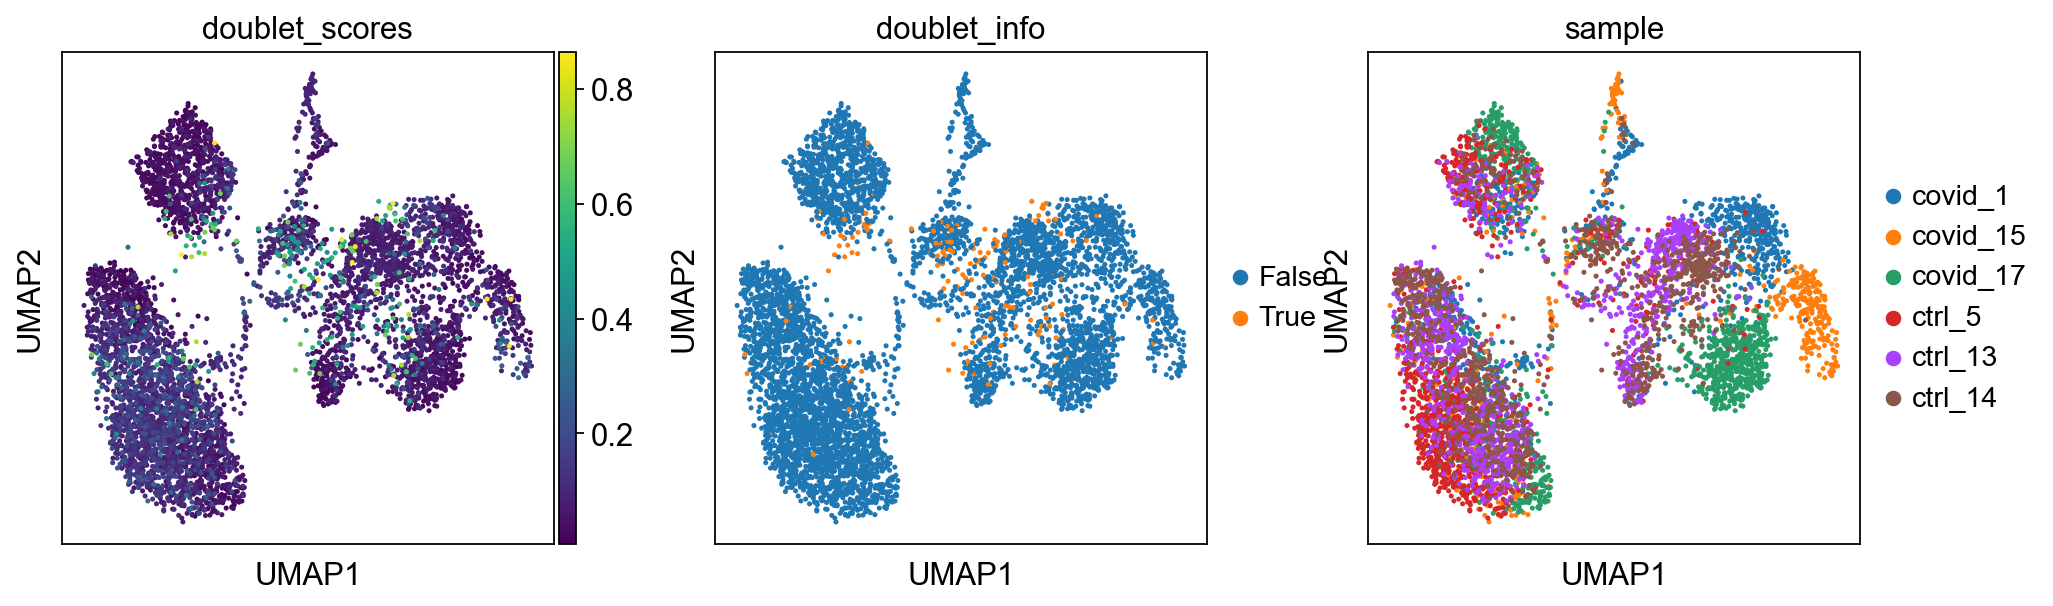

In [33]:
sc.pl.umap(adata, color=["doublet_scores", "doublet_info", "sample"])

Now, lets remove all predicted doublets from our data.


In [34]:
# also revert back to the raw counts as the main matrix in adata
adata = adata.raw.to_adata()

adata = adata[adata.obs["doublet_info"] == "False", :]
print(adata.shape)

(5594, 18752)


In [35]:
# # Save the QC-filtered data
# import os
# os.makedirs('data/results/', exist_ok=True)

# save_file = 'data/results/scanpy_preprocess_classification.h5ad'
# adata.write_h5ad(save_file)

# Dimensionality Reduction

## Data preparation

In [36]:
adata

View of AnnData object with n_obs × n_vars = 5594 × 18752
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'sample_colors', 'log1p', 'doublet_info_colors', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [37]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

# store normalized counts in the raw slot,
# we will subset adata.X for variable genes, but want to keep all genes matrix as well.
adata.raw = adata

adata

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


AnnData object with n_obs × n_vars = 5594 × 18752
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'sample_colors', 'log1p', 'doublet_info_colors', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

Next, we first need to define which features/genes are important in our dataset to distinguish cell types. For this purpose, we need to find genes that are highly variable across cells, which in turn will also provide a good separation of the cell clusters.


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 3066


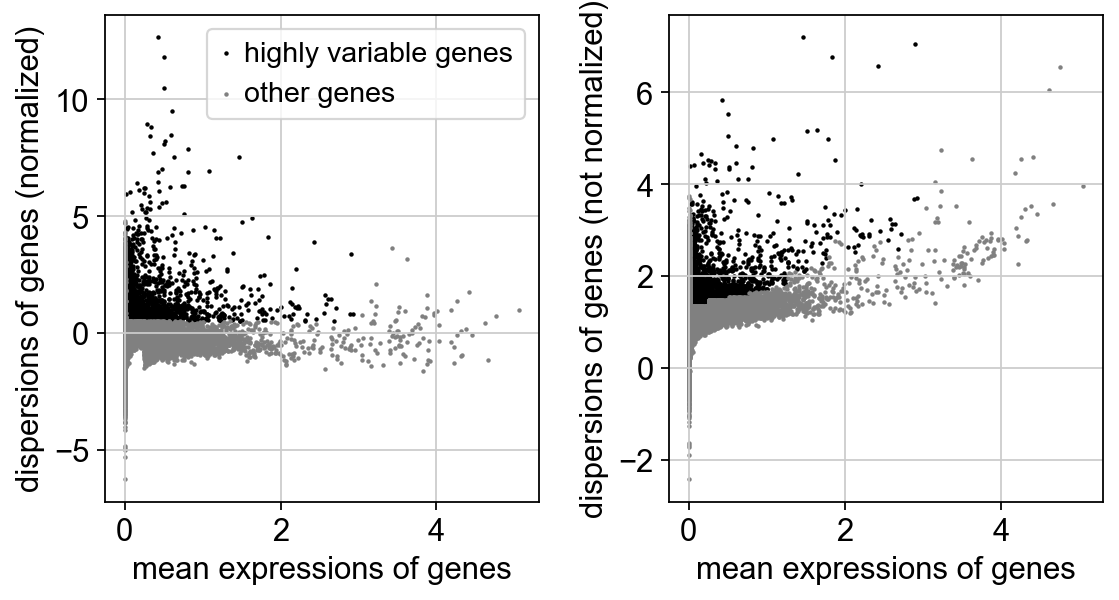

In [38]:
# compute variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d" % sum(adata.var.highly_variable))

# plot variable genes
sc.pl.highly_variable_genes(adata)

# subset for variable genes in the dataset
adata = adata[:, adata.var["highly_variable"]]

In [39]:
# adata

### Z-score transformation

Now that the data is prepared, we now proceed with PCA. Since each gene has a different expression level, it means that genes with higher expression values will naturally have higher variation that will be captured by PCA. This means that we need to somehow give each gene a similar weight when performing PCA (see below). The common practice is to center and scale each gene before performing PCA. This exact scaling is called Z-score normalization it is very useful for PCA, clustering and plotting heatmaps. <br>Additionally, we can use regression to remove any unwanted sources of variation from the dataset, such as `cell cycle`, `sequencing depth`, `percent mitocondria`. This is achieved by doing a generalized linear regression using these parameters as covariates in the model. Then the residuals of the model are taken as the "regressed data". Although perhaps not in the best way, batch effect regression can also be done here.


In [40]:
# adata = adata.copy()     #run this line if you get the "AttributeError: swapaxes not found"

# regress out unwanted variables
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

# scale data, clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:07)


## PCA
***

Performing PCA has many useful applications and interpretations, which much depends on the data used. In the case of life sciences, we want to segregate samples based on gene expression patterns in the data.


In [41]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


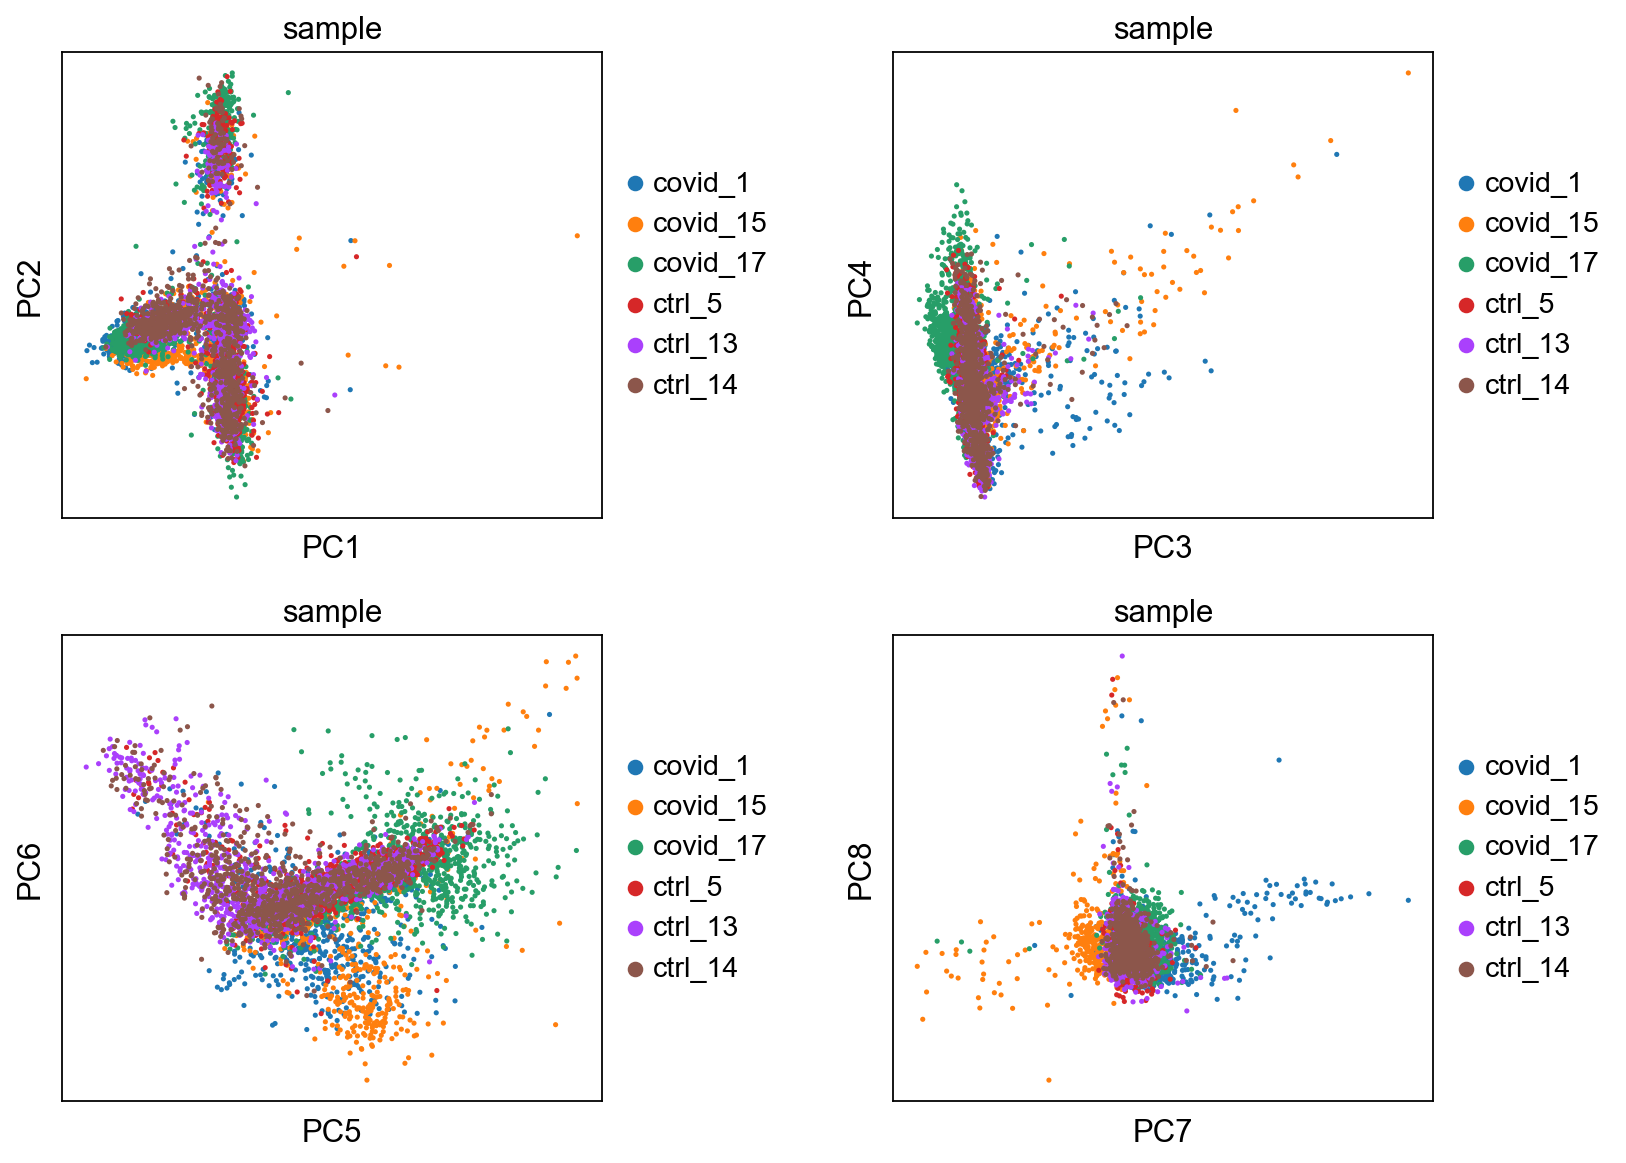

In [42]:
# plot more PCS
sc.pl.pca(adata, color="sample", components=["1,2", "3,4", "5,6", "7,8"], ncols=2, wspace=0.4)
# color: Keys for annotations of observations/cells or variables/genes

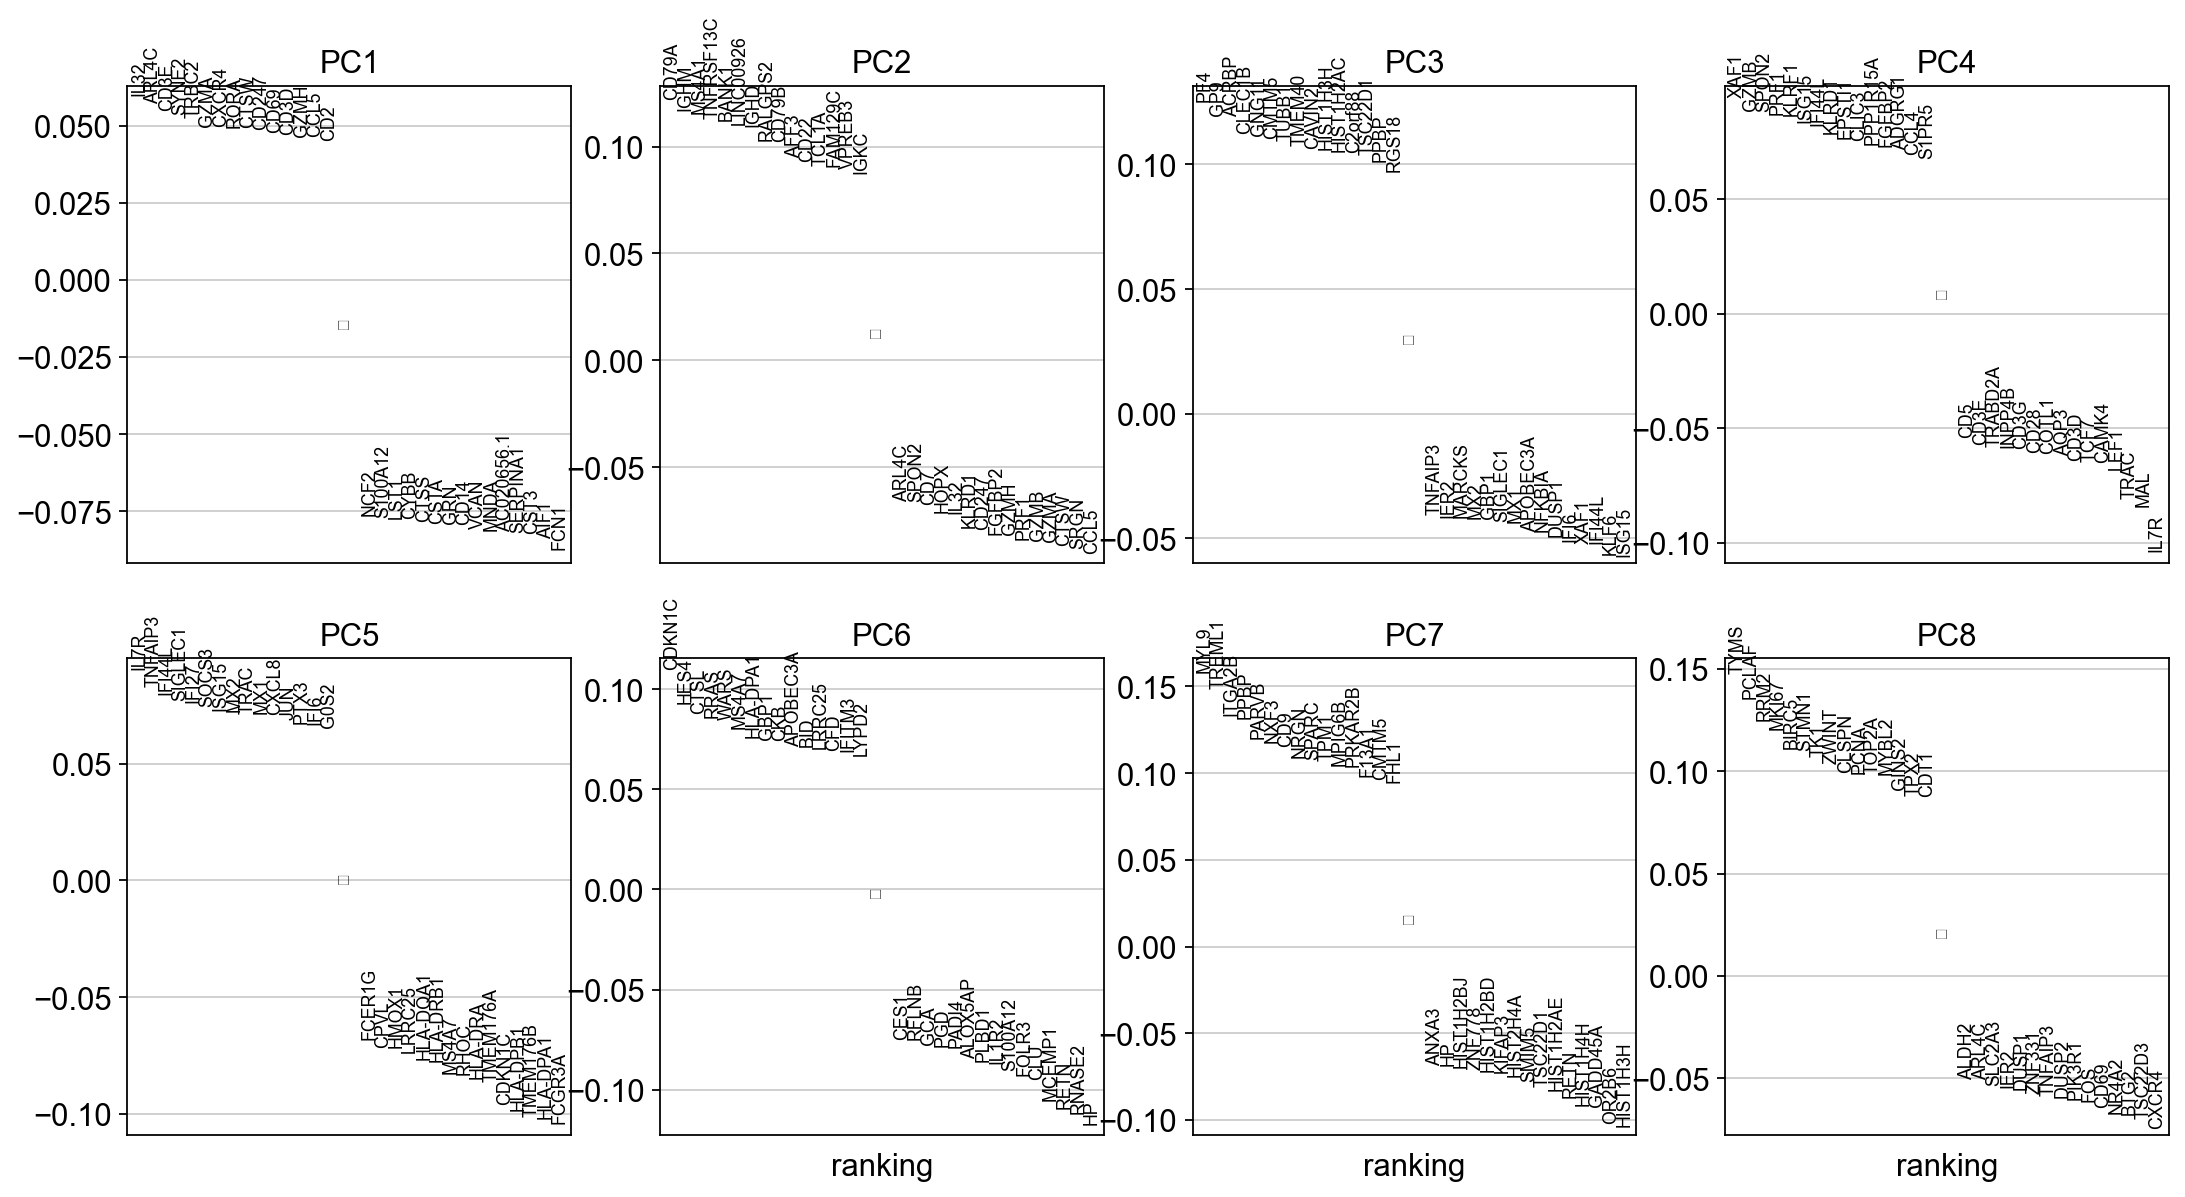

In [43]:
# Plot loadings
sc.pl.pca_loadings(adata, components=[1, 2, 3, 4, 5, 6, 7, 8])

# OBS! only plots the positive axes genes from each PC!!

We can also plot the amount of variance explained by each PC.


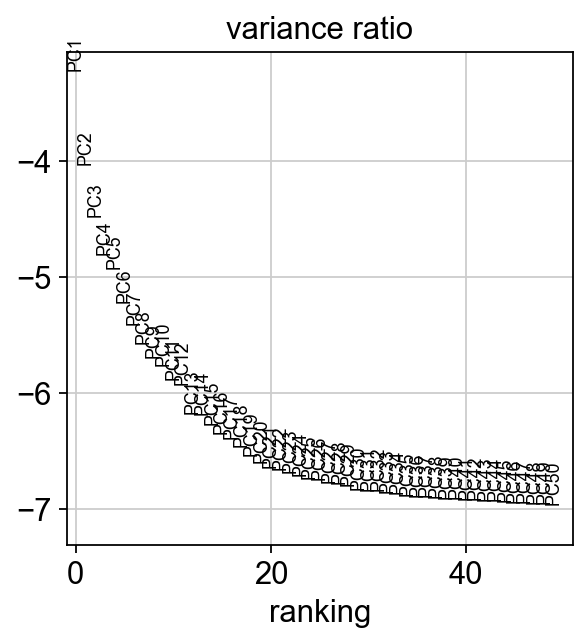

In [44]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

## tSNE
***
We can now run [BH-tSNE](https://arxiv.org/abs/1301.3342).


In [45]:
sc.tl.tsne(adata, n_pcs=30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:12)


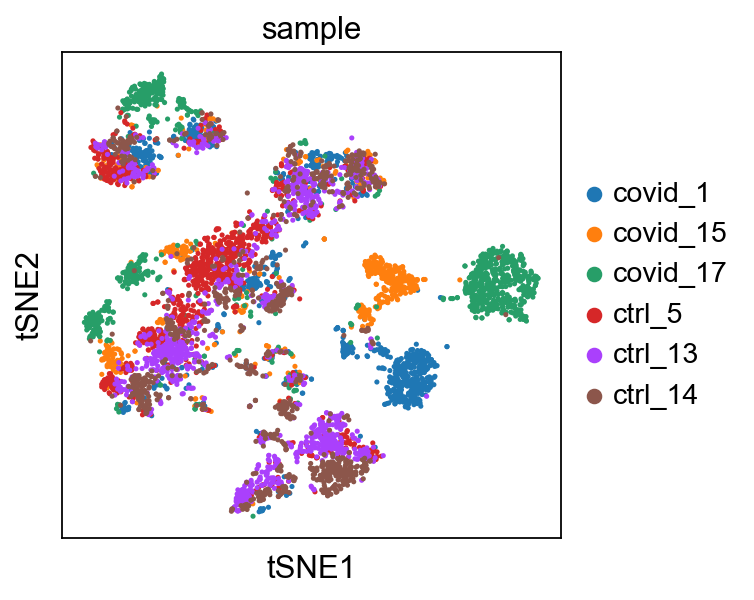

In [46]:
sc.pl.tsne(adata, color="sample")

## UMAP
***

We can now run [UMAP](https://arxiv.org/abs/1802.03426) for cell embeddings.

### Calculate neighborhood graph

The UMAP implementation in SCANPY uses a neighborhood graph as the distance matrix, so we need to first calculate the graph.


In [47]:
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [48]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


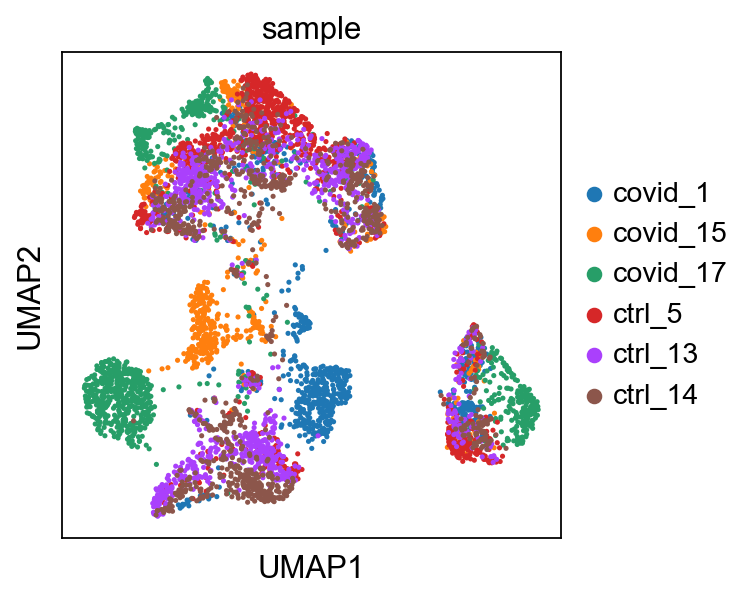

In [49]:
sc.pl.umap(adata, color="sample")

In [50]:
# Save the pre-process data
import os

os.makedirs("data/results/", exist_ok=True)

save_file = "data/results/scanpy_preprocess_classification.h5ad"
adata.write_h5ad(save_file)

## Sample Classification

### Input data
PCA representation (pca 1 - pca 15)

Train dataset:
covid_1, covid_15, ctrl_5, ctl_13
Test dataset:
covid_17, ctlr_14

### Classification model
Binary classification (covid or non_covid). <br>
• 'covid_" -> covid <br>
• "ctlr_" -> non_covid.

In [52]:
# Read pre-processed data
save_file = "data/results/scanpy_preprocess_classification.h5ad"
adata = sc.read_h5ad(save_file)

In [53]:
# PoC: using from PCA1 and PCA15 as input features.
adata.obs

type   sample batch  n_genes_by_counts  total_counts  \
AGGGTCCCATGACCCG-1-0   Covid  covid_1     0               2140        7698.0   
TACCCACAGCGGGTTA-1-0   Covid  covid_1     0               3391       13416.0   
CCCAACTTCATATGGC-1-0   Covid  covid_1     0               3654       16498.0   
TCAAGTGTCCGAACGC-1-0   Covid  covid_1     0                608        1425.0   
ATTCCTAGTGACTGTT-1-0   Covid  covid_1     0               1808        7535.0   
...                      ...      ...   ...                ...           ...   
CGCATAATCTTACGGA-14-5   Ctrl  ctrl_14     5               1460        3583.0   
GAGGCCTTCTCCTGCA-14-5   Ctrl  ctrl_14     5               1155        2711.0   
CCCTAACAGTTTCTTC-14-5   Ctrl  ctrl_14     5               1921        5913.0   
GGGATGATCAAGCTTG-14-5   Ctrl  ctrl_14     5               1926        7393.0   
CAATGACCACTGCATA-14-5   Ctrl  ctrl_14     5               2075        6220.0   

                       total_counts_mt  pct_counts_mt  total_counts_ribo  \
AGGGTCCCATGACCCG-1-0             525.0       6.819953             2564.0   
TACCCACAGCGGGTTA-1-0             952.0       7.096004             2264.0   
CCCAACTTCATATGGC-1-0            1253.0       7.594861             2723.0   
TCAAGTGTCCGAACGC-1-0             141.0       9.894737              444.0   
ATTCCTAGTGACTGTT-1-0             470.0       6.237558             3397.0   
...                                ...            ...                ...   
CGCATAATCTTACGGA-14-5            358.0       9.991627              563.0   
GAGGCCTTCTCCTGCA-14-5             96.0       3.541129              608.0   
CCCTAACAGTTTCTTC-14-5            235.0       3.974294             1813.0   
GGGATGATCAAGCTTG-14-5            385.0       5.207629             3001.0   
CAATGACCACTGCATA-14-5            415.0       6.672026             1572.0   

                       pct_counts_ribo  total_counts_hb  pct_counts_hb  \
AGGGTCCCATGACCCG-1-0         33.307354              2.0       0.025981   
TACCCACAGCGGGTTA-1-0         16.875372              6.0       0.044723   
CCCAACTTCATATGGC-1-0         16.505032              1.0       0.006061   
TCAAGTGTCCGAACGC-1-0         31.157896              1.0       0.070175   
ATTCCTAGTGACTGTT-1-0         45.082947              4.0       0.053086   
...                                ...              ...            ...   
CGCATAATCTTACGGA-14-5        15.713090              0.0       0.000000   
GAGGCCTTCTCCTGCA-14-5        22.427149             25.0       0.922169   
CCCTAACAGTTTCTTC-14-5        30.661255              0.0       0.000000   
GGGATGATCAAGCTTG-14-5        40.592453              0.0       0.000000   
CAATGACCACTGCATA-14-5        25.273312              1.0       0.016077   

                       percent_mt2  n_counts  n_genes   S_score  G2M_score  \
AGGGTCCCATGACCCG-1-0      0.068200    6801.0     2140 -0.041544  -0.369570   
TACCCACAGCGGGTTA-1-0      0.070960   12253.0     3391 -0.175093  -0.619071   
CCCAACTTCATATGGC-1-0      0.075949   14941.0     3654 -0.122379  -0.594659   
TCAAGTGTCCGAACGC-1-0      0.098947    1143.0      608 -0.017833  -0.062375   
ATTCCTAGTGACTGTT-1-0      0.062376    6680.0     1808 -0.046149  -0.400857   
...                            ...       ...      ...       ...        ...   
CGCATAATCTTACGGA-14-5     0.099916    2899.0     1460 -0.003135  -0.111798   
GAGGCCTTCTCCTGCA-14-5     0.035411    2367.0     1155 -0.007741  -0.097549   
CCCTAACAGTTTCTTC-14-5     0.039743    5133.0     1921 -0.055752  -0.220108   
GGGATGATCAAGCTTG-14-5     0.052076    6592.0     1926 -0.068097  -0.403647   
CAATGACCACTGCATA-14-5     0.066720    5516.0     2075 -0.000784  -0.276704   

                      phase  doublet_scores  predicted_doublets doublet_info  
AGGGTCCCATGACCCG-1-0     G1        0.168207               False        False  
TACCCACAGCGGGTTA-1-0     G1        0.070601               False        False  
CCCAACTTCATATGGC-1-0     G1        0.132193               False        False  
TCAAGTGT

### Add a new columns: covid_non_covid to adata.obs

This allows us to visualize clusters in UMAP with only a covid patients and non-covid patients.

In [55]:
list_covid = ["covid_1", "covid_15", "covid_17"]
list_non_covid = ["ctrl_5", "ctrl_13", "ctrl_14"]

for index, row in adata.obs.iterrows():
    if row["sample"] in list_covid:
        new_value = "covid"
    elif row["sample"] in list_non_covid:
        new_value = "non_covid"

    adata.obs.at[index, "covid_non_covid"] = new_value

In [275]:
# Get the feature of PCA 1 and 2
pca_rep = adata.obsm["X_pca"][:, :15]
pca_rep.shape  # number of cells * PCA1 & PCA2

(5594, 15)

In [276]:
df_obs = adata.obs

list_sample = ["covid_1", "covid_15", "covid_17", "ctrl_5", "ctrl_13", "ctrl_14"]
sample_range = dict()
y = []
beginning = 0
for sample in list_sample:
    sample_range[sample] = [beginning, beginning + len(df_obs[df_obs["sample"] == sample].index.to_list())]
    beginning = len(df_obs[df_obs["sample"] == sample].index.to_list()) + beginning

print(f"Sample range: {sample_range}")

Sample range: {'covid_1': [0, 854], 'covid_15': [854, 1435], 'covid_17': [1435, 2463], 'ctrl_5': [2463, 3482], 'ctrl_13': [3482, 4606], 'ctrl_14': [4606, 5594]}


In [277]:
train_sample = np.array(["covid_1", "covid_15", "ctrl_5", "ctrl_13"])
np.random.shuffle(train_sample)

test_sample = ["covid_17", "ctrl_14"]
X_train = []
y_train = []
X_test = []
y_test = []
y_test_sample_range = dict()
begin = 0
for sample, list_range in sample_range.items():
    if sample in train_sample:
        for i in range(list_range[0], list_range[1]):
            X_train.append(pca_rep[i])
            if "covid" in sample:
                y_train.append("covid")
            else:
                y_train.append("non_covid")
    else:
        for i in range(list_range[0], list_range[1]):
            X_test.append(pca_rep[i])
            if "covid" in sample:
                y_test.append("covid")
                s = "covid"
            else:
                y_test.append("non_covid")
                s = "non_covid"
        y_test_sample_range[s] = [begin, len(y_test)]
        begin = len(y_test)

In [278]:
print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)

(3578, 15)
(2016, 15)
(3578,)
(2016,)


In [279]:
y_test_sample_range

{'covid': [0, 1028], 'non_covid': [1028, 2016]}

In [280]:
# # Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
# X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0,random_state=10) # 80% training and 20% test
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=10)

print(f"Numbeer of train data: {len(X_train)}")
print(f"Number of test data: {len(X_test)}")

Numbeer of train data: 3578
Number of test data: 2016


In [281]:
# Import svm model
from sklearn import svm

# Create a svm Classifier
clf = svm.SVC(kernel="linear")  # Linear Kernel

# Train the model using the training sets
clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

In [282]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, y_pred, average="micro"))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test, y_pred, average="micro"))

Accuracy: 0.6349206349206349
Precision: 0.6349206349206349
Recall: 0.6349206349206349


In [283]:
# Count the predicted labels for each data point (x, y), then get the label which has the most count.
for sample, r in y_test_sample_range.items():
    unique, counts = np.unique(y_pred[r[0] : r[1]], return_counts=True)
    print(np.asarray((unique, counts)).T)
    pred_label = unique[np.where(counts == counts.max())[0]]
    print("Predicted label:", pred_label[0])

[['covid' '563']
 ['non_covid' '465']]
Predicted label: covid
[['covid' '271']
 ['non_covid' '717']]
Predicted label: non_covid


## Sample Classification

### Input data
UMAP representation (UMAP 1 - UMAP 10)

Train dataset:
covid_1, covid_15, ctrl_5, ctl_13
Test dataset:
covid_17, ctlr_14

### Classification model
Binary classification (covid or non_covid). <br>
• 'covid_" -> covid <br>
• "ctlr_" -> non_covid.

In [293]:
sc.tl.umap(adata, n_components=10)

# Get the feature from UMAP1 to UMAP10
umap_rep = adata.obsm["X_umap"]
umap_rep.shape  # number of cells * UMAP1-10

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


(5594, 10)

In [295]:
train_sample = np.array(["covid_1", "covid_15", "ctrl_5", "ctrl_13"])
np.random.shuffle(train_sample)

test_sample = ["covid_17", "ctrl_14"]
X_train = []
y_train = []
X_test = []
y_test = []
y_test_sample_range = dict()
begin = 0
for sample, list_range in sample_range.items():
    if sample in train_sample:
        for i in range(list_range[0], list_range[1]):
            X_train.append(umap_rep[i])
            if "covid" in sample:
                y_train.append("covid")
            else:
                y_train.append("non_covid")
    else:
        for i in range(list_range[0], list_range[1]):
            X_test.append(umap_rep[i])
            if "covid" in sample:
                y_test.append("covid")
                s = "covid"
            else:
                y_test.append("non_covid")
                s = "non_covid"
        y_test_sample_range[s] = [begin, len(y_test)]
        begin = len(y_test)

print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)
print(y_test_sample_range)

(3578, 10)
(2016, 10)
(3578,)
(2016,)
{'covid': [0, 1028], 'non_covid': [1028, 2016]}


In [296]:
# # Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
# X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0,random_state=10) # 80% training and 20% test
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=10)

print(f"Numbeer of train data: {len(X_train)}")
print(f"Number of test data: {len(X_test)}")

Numbeer of train data: 3578
Number of test data: 2016


In [297]:
# Import svm model
from sklearn import svm

# Create a svm Classifier
clf = svm.SVC(kernel="linear")  # Linear Kernel

# Train the model using the training sets
clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

In [298]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, y_pred, average="micro"))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test, y_pred, average="micro"))

Accuracy: 0.7921626984126984
Precision: 0.7921626984126984
Recall: 0.7921626984126984


In [299]:
# Count the predicted labels for each data point (x, y), then get the label which has the most count.
for sample, r in y_test_sample_range.items():
    unique, counts = np.unique(y_pred[r[0] : r[1]], return_counts=True)
    print(np.asarray((unique, counts)).T)
    pred_label = unique[np.where(counts == counts.max())[0]]
    print("Predicted label:", pred_label[0])

[['covid' '713']
 ['non_covid' '315']]
Predicted label: covid
[['covid' '104']
 ['non_covid' '884']]
Predicted label: non_covid
